# Best vs Worst permutation visualization

Given a `procedure`, `ablation`, `policy_name`, `metric`, and `subset_index`, this notebook:

1. Finds the best and worst permutation within that subset by permutation-average metric.
2. Visualizes the first 3 images from each permutation order.
3. Visualizes the full subset image order for best and worst permutations.

Adjust the config cell first.

In [67]:
from pathlib import Path
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

REPO_ROOT = Path('/data/ddmg/mvseg-ordering')
for path in [REPO_ROOT, REPO_ROOT / 'UniverSeg', REPO_ROOT / 'MultiverSeg', REPO_ROOT / 'ScribblePrompt']:
    if str(path) not in sys.path:
        sys.path.append(str(path))

from experiments.analysis.planb_utils import load_planb_summaries
from experiments.dataset.mega_medical_dataset import MegaMedicalDataset

# ---- Config ----
procedure = 'random'
ablation = 'commit_label_90'
policy_name = 'random'
metric = 'iterations_used'
subset_index = 5

# Select task by dataset + dataset index encoded in task_id suffix (_idx###).
dataset = 'WBC'
task_idx = 638

# MegaMedical split used to retrieve raw images by image_id.
dataset_split = 'train'

In [68]:
def parse_task_dir(task_dir: str):
    """Return (task, label, slicing) from task dir name."""
    m = re.match(r'^(?P<base>.+)_label(?P<label>\d+)_(?P<slicing>midslice|maxslice)_idx(?P<idx>\d+)$', task_dir)
    if not m:
        raise ValueError(f'Unexpected task dir format: {task_dir}')
    base = m.group('base')
    label = int(m.group('label'))
    slicing = m.group('slicing')
    task = base.replace('_', '/')
    return task, label, slicing


def extract_image(sample):
    """Extract image tensor/array from a dataset sample."""
    if isinstance(sample, dict):
        if 'img' in sample:
            return sample['img']
        if 'image' in sample:
            return sample['image']
        return next(iter(sample.values()))
    if isinstance(sample, (tuple, list)):
        return sample[0]
    return sample


def to_numpy_img(img):
    """Convert tensor-like image to numpy and normalize shape for imshow."""
    if hasattr(img, 'detach'):
        img = img.detach().cpu()
    if hasattr(img, 'numpy'):
        img = img.numpy()
    arr = np.asarray(img)
    arr = np.squeeze(arr)

    # (C,H,W) -> (H,W,C)
    if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[0] < arr.shape[-1]:
        arr = np.transpose(arr, (1, 2, 0))

    # (H,W,1) -> (H,W)
    if arr.ndim == 3 and arr.shape[-1] == 1:
        arr = arr[..., 0]

    return arr


def is_higher_better(metric_name: str) -> bool:
    lower_is_better = {'iterations_used'}
    return metric_name not in lower_is_better

In [69]:
# ---- Load Plan B summary rows and resolve task by dataset index ----
all_df = load_planb_summaries(
    repo_root=REPO_ROOT,
    procedure=procedure,
    ablation=ablation,
    dataset=dataset,
)

policy_df = all_df[all_df['policy_name'] == policy_name].copy()
if policy_df.empty:
    raise ValueError(
        f'No rows found for dataset={dataset}, policy={policy_name}, '
        f'procedure={procedure}, ablation={ablation}.'
    )

all_task_ids = sorted(policy_df['task_id'].dropna().unique().tolist())

def task_id_to_dataset_index(tid: str) -> int | None:
    task_dir = tid.split('/', 1)[-1]
    m = re.search(r'_idx(\d+)$', task_dir)
    if not m:
        return None
    return int(m.group(1))

matches = [tid for tid in all_task_ids if task_id_to_dataset_index(tid) == task_idx]

if not matches:
    available_indices = sorted({task_id_to_dataset_index(tid) for tid in all_task_ids if task_id_to_dataset_index(tid) is not None})
    raise ValueError(
        f'No task found for dataset={dataset}, task_idx={task_idx}.\n'
        f'Available dataset indices for this policy: {available_indices}'
    )

if len(matches) > 1:
    raise ValueError(
        f'Multiple task_ids matched task_idx={task_idx}. Please disambiguate manually.\n'
        + '\n'.join(f'  {tid}' for tid in matches)
    )

task_id = matches[0]
print(f'Selected task_id for dataset index {task_idx}: {task_id}')

df = policy_df[
    (policy_df['task_id'] == task_id)
    & (policy_df['subset_index'] == subset_index)
].copy()

if df.empty:
    raise ValueError(
        f'No rows found for selected filters after task resolution: '
        f'task_id={task_id}, subset_index={subset_index}. '
        f'Available subset_index values: {sorted(policy_df[policy_df["task_id"] == task_id]["subset_index"].unique().tolist())}'
    )

if metric not in df.columns:
    raise ValueError(f'Metric {metric!r} not found. Available columns: {sorted(df.columns)}')

perm_scores = (
    df.groupby('permutation_index', as_index=False)[metric]
    .mean()
    .rename(columns={metric: 'perm_metric'})
)

higher_is_better = is_higher_better(metric)
best_row = perm_scores.loc[perm_scores['perm_metric'].idxmax()] if higher_is_better else perm_scores.loc[perm_scores['perm_metric'].idxmin()]
worst_row = perm_scores.loc[perm_scores['perm_metric'].idxmin()] if higher_is_better else perm_scores.loc[perm_scores['perm_metric'].idxmax()]

best_perm = int(best_row['permutation_index'])
worst_perm = int(worst_row['permutation_index'])

best_df = df[df['permutation_index'] == best_perm].sort_values('image_index').copy()
worst_df = df[df['permutation_index'] == worst_perm].sort_values('image_index').copy()

best_order_ids = [int(x) for x in best_df['image_id'].tolist()]
worst_order_ids = [int(x) for x in worst_df['image_id'].tolist()]
subset_image_ids = sorted(int(x) for x in df['image_id'].unique())

print(f'Metric: {metric} (higher_is_better={higher_is_better})')
print(f'Subset index: {subset_index}')
print(f'Best permutation: {best_perm} score={best_row["perm_metric"]:.6f}')
print(f'Worst permutation: {worst_perm} score={worst_row["perm_metric"]:.6f}')
print(f'Subset size: {len(subset_image_ids)} images')

perm_scores.sort_values('perm_metric', ascending=not higher_is_better).head()

Selected task_id for dataset index 638: WBC/WBC_CV_EM_0_label0_maxslice_idx638
Metric: iterations_used (higher_is_better=False)
Subset index: 5
Best permutation: 17 score=2.300000
Worst permutation: 19 score=4.500000
Subset size: 10 images


,permutation_index,perm_metric
17,17,2.3
60,60,2.3
85,85,2.3
89,89,2.3
38,38,2.4


In [70]:
# ---- Load all subset images once by image_id ----
task_dir = task_id.split('/', 1)[1]
task, label, slicing = parse_task_dir(task_dir)

ds = MegaMedicalDataset(
    task=task,
    label=label,
    slicing=slicing,
    split=dataset_split,
    dataset_size=None,
)

images_by_id = {}
for img_id in subset_image_ids:
    sample = ds.get_item_by_data_index(img_id)
    images_by_id[img_id] = to_numpy_img(extract_image(sample))

print(f'Loaded {len(images_by_id)} images for subset visualization.')

No updates to index
Filtered task_df: 1248
got task df: 1248


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


target_datasets: 1248
Loaded 10 images for subset visualization.


In [71]:
def _draw_single(ax, img, title, highlight=False):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor('red' if highlight else 'black')
        spine.set_linewidth(3 if highlight else 1)


def plot_first_three(best_ids, worst_ids, img_map):
    """Plot first 3 images from best and worst permutation orders."""
    ncols = 3
    fig, axes = plt.subplots(2, ncols, figsize=(4 * ncols, 7))

    for c in range(ncols):
        if c < len(best_ids):
            img_id = best_ids[c]
            _draw_single(
                axes[0, c],
                img_map[img_id],
                title=f'Best pos={c} id={img_id}',
                highlight=(c == 0),
            )
        else:
            axes[0, c].axis('off')

        if c < len(worst_ids):
            img_id = worst_ids[c]
            _draw_single(
                axes[1, c],
                img_map[img_id],
                title=f'Worst pos={c} id={img_id}',
                highlight=(c == 0),
            )
        else:
            axes[1, c].axis('off')

    fig.suptitle(
        f'First 3 images | subset={subset_index} | best_perm={best_perm} vs worst_perm={worst_perm}',
        fontsize=14,
    )
    plt.tight_layout()
    plt.show()


def plot_full_order(order_ids, img_map, title, ncols=5):
    """Plot the full image order for one permutation."""
    n = len(order_ids)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2 * ncols, 3.2 * nrows))
    axes = np.array(axes).reshape(-1)

    for i, img_id in enumerate(order_ids):
        _draw_single(
            axes[i],
            img_map[img_id],
            title=f'pos={i} id={img_id}',
            highlight=(i == 0),
        )

    for j in range(n, len(axes)):
        axes[j].axis('off')

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

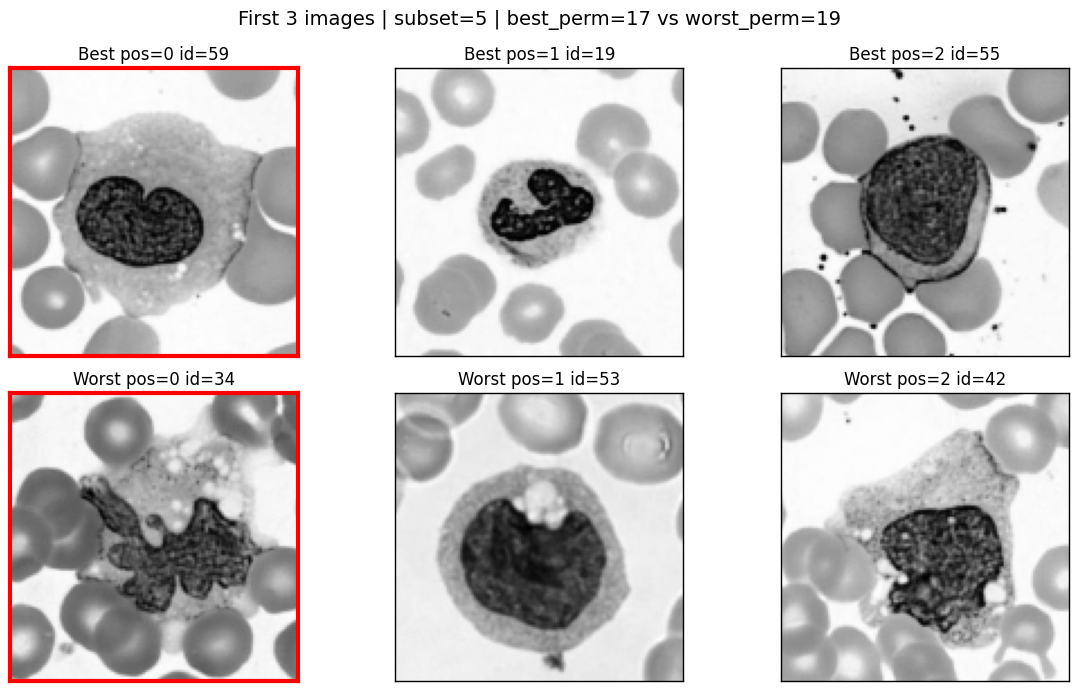

In [72]:
# ---- Visualize: first 3 images ----
plot_first_three(best_order_ids, worst_order_ids, images_by_id)

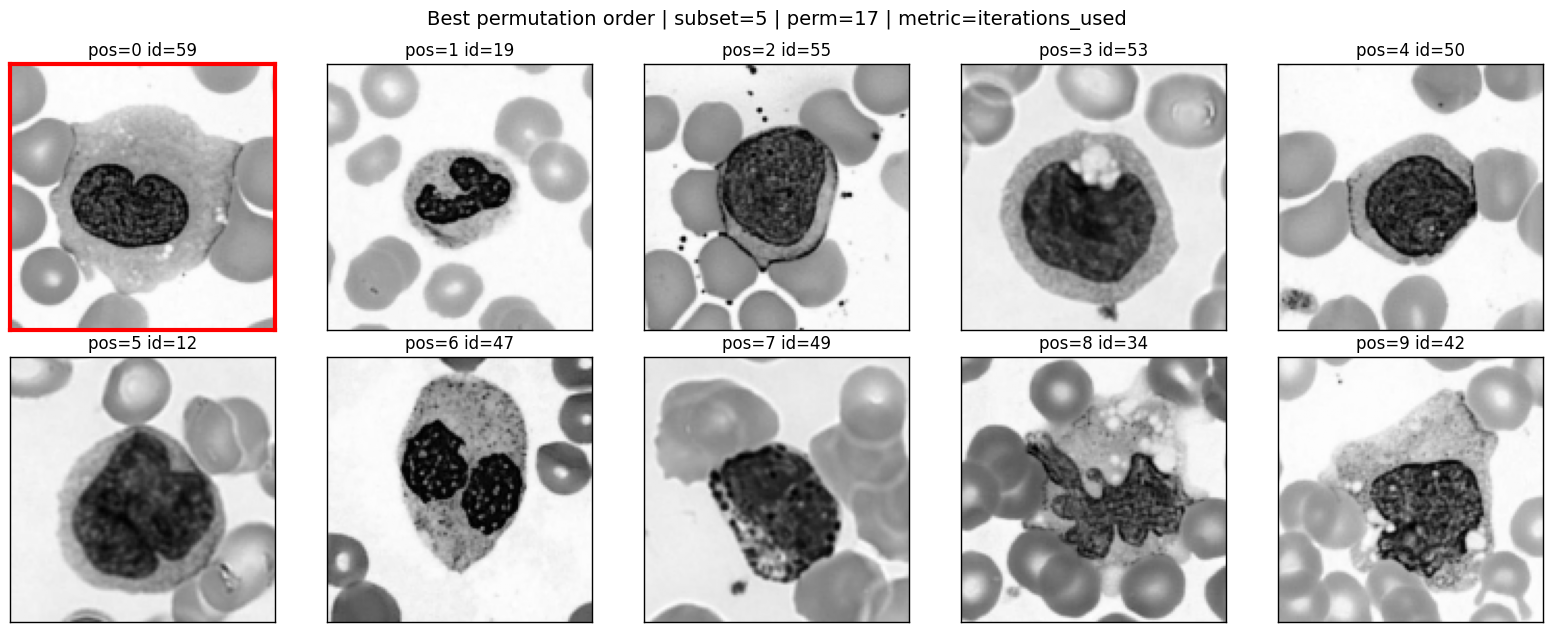

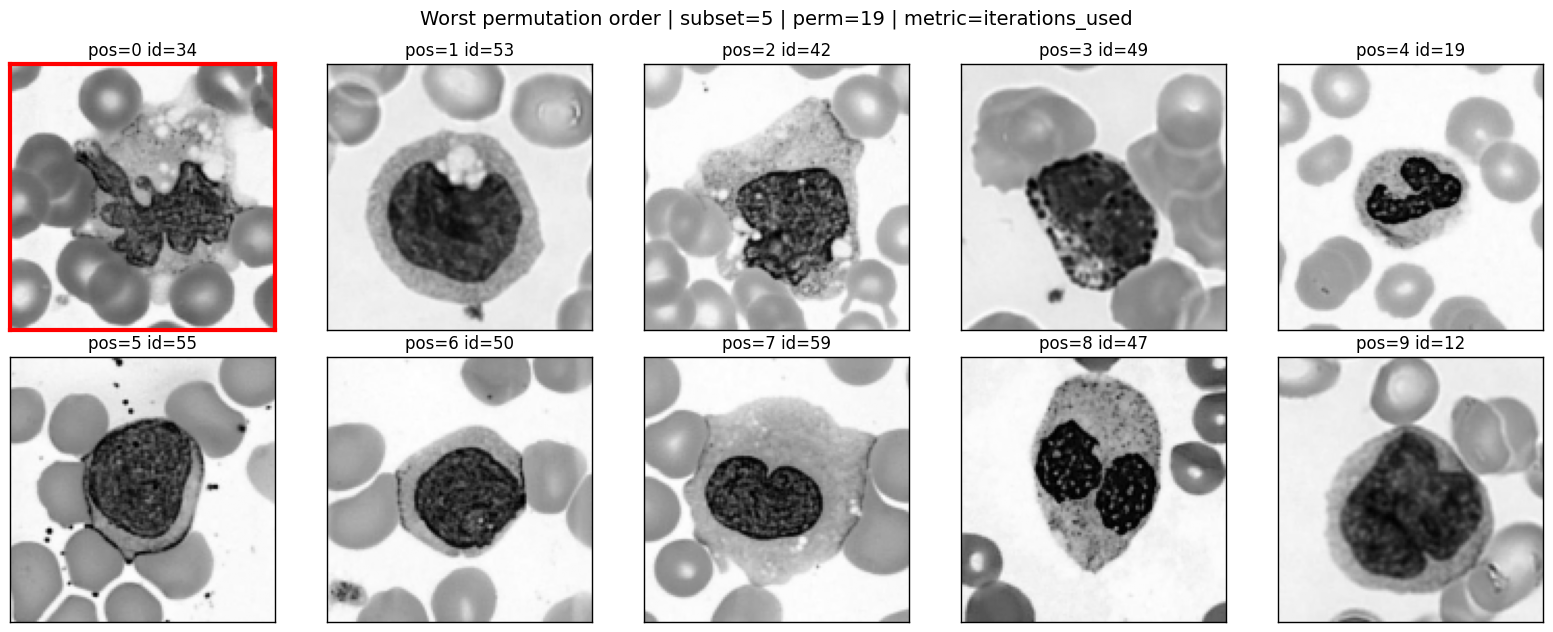

In [73]:
# ---- Visualize: full best and full worst orders ----
plot_full_order(
    best_order_ids,
    images_by_id,
    title=f'Best permutation order | subset={subset_index} | perm={best_perm} | metric={metric}',
)

plot_full_order(
    worst_order_ids,
    images_by_id,
    title=f'Worst permutation order | subset={subset_index} | perm={worst_perm} | metric={metric}',
)